In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [7]:
# Load the dataset
df = pd.read_csv(r"C:\Users\Shelter\Downloads\data\RELAY_WHS.csv")

# Initial inspection
print(df.head())
print(df.info())
print(df.describe())

                         IND_ID               IND_CODE IND_UUID  \
0  442CEA8MALARIA_EST_INCIDENCE  MALARIA_EST_INCIDENCE  442CEA8   
1  442CEA8MALARIA_EST_INCIDENCE  MALARIA_EST_INCIDENCE  442CEA8   
2  442CEA8MALARIA_EST_INCIDENCE  MALARIA_EST_INCIDENCE  442CEA8   
3  442CEA8MALARIA_EST_INCIDENCE  MALARIA_EST_INCIDENCE  442CEA8   
4  442CEA8MALARIA_EST_INCIDENCE  MALARIA_EST_INCIDENCE  442CEA8   

            IND_PER_CODE  DIM_TIME DIM_TIME_TYPE  DIM_GEO_CODE_M49  \
0  MALARIA_EST_INCIDENCE      2001          YEAR               364   
1  MALARIA_EST_INCIDENCE      2001          YEAR               368   
2  MALARIA_EST_INCIDENCE      2001          YEAR               384   
3  MALARIA_EST_INCIDENCE      2001          YEAR               404   
4  MALARIA_EST_INCIDENCE      2001          YEAR               408   

  DIM_GEO_CODE_TYPE DIM_PUBLISH_STATE_CODE       IND_NAME  \
0           COUNTRY              PUBLISHED  Malaria cases   
1           COUNTRY              PUBLISHED  Malaria ca

In [8]:
clean_df = df.dropna()

In [10]:
df['RATE_PER_1000_N'] = df['RATE_PER_1000_N'].fillna(df['RATE_PER_1000_N'].mean())

In [11]:
df['RATE_MISSING'] = df['RATE_PER_1000_N'].isna().astype(int)

In [12]:
# Standardize country names
df['GEO_NAME_SHORT'] = df['GEO_NAME_SHORT'].str.strip().str.title()

# Fix inconsistent codes (if any)
df['DIM_GEO_CODE_M49'] = df['DIM_GEO_CODE_M49'].astype(int)

In [18]:
import pandas as pd
import numpy as np
from scipy import stats

In [19]:
# Drop or fill NA values before calculating z-scores
df['RATE_PER_1000_N'] = df['RATE_PER_1000_N'].dropna()

In [20]:
# Convert year to proper datetime
df['Year'] = pd.to_datetime(df['DIM_TIME'], format='%Y')

# Ensure numeric columns are numeric
df['RATE_PER_1000_N'] = pd.to_numeric(df['RATE_PER_1000_N'], errors='coerce')

In [22]:
# Step 1: Ensure no missing values exist in your time series
df['RATE_PER_1000_N'] = df.groupby('DIM_GEO_CODE_M49')['RATE_PER_1000_N'].ffill()

# Step 2: Calculate percentage change without fill
df['Rate_Change'] = df.groupby('DIM_GEO_CODE_M49')['RATE_PER_1000_N'].pct_change(fill_method=None)

# Optional: Fill resulting NA values (first year has no change)
df['Rate_Change'] = df['Rate_Change'].fillna(0)

In [23]:
# Filter for Rwanda only
rwanda_df = df[df['DIM_GEO_CODE_M49'] == 646]

# Filter time period
rwanda_df = rwanda_df[(rwanda_df['Year'] >= 2000) & (rwanda_df['Year'] <= 2019)]

In [24]:
# Check for duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

# Remove duplicates
df = df.drop_duplicates()

Duplicate rows: 0


In [25]:
# Clean the IND_NAME column if needed
df['IND_NAME'] = df['IND_NAME'].str.strip().str.lower()

In [26]:
# Save cleaned data
clean_df.to_csv('cleaned_malaria_data.csv', index=False)

In [29]:
# Check column names exist:
print("full_years columns:", full_years.columns)
print("clean_df columns:", clean_df.columns)

# Ensure both have 'Year' column (case-sensitive)

full_years columns: Index(['Year'], dtype='object')
clean_df columns: Index(['IND_ID', 'IND_CODE', 'IND_UUID', 'IND_PER_CODE', 'DIM_TIME',
       'DIM_TIME_TYPE', 'DIM_GEO_CODE_M49', 'DIM_GEO_CODE_TYPE',
       'DIM_PUBLISH_STATE_CODE', 'IND_NAME', 'GEO_NAME_SHORT',
       'RATE_PER_1000_N', 'RATE_PER_1000_NL', 'RATE_PER_1000_NU'],
      dtype='object')


<Axes: xlabel='DIM_TIME', ylabel='RATE_PER_1000_N'>

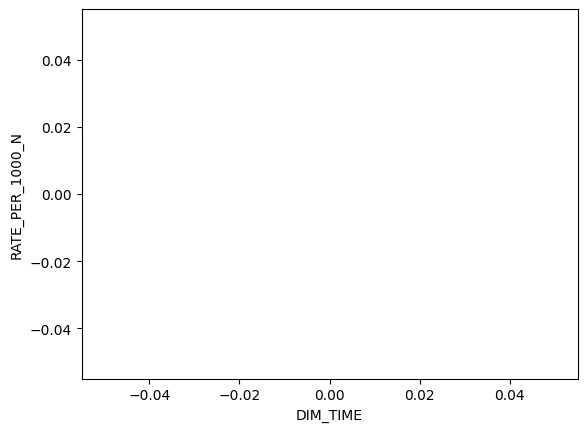

In [31]:
# Corrected data cleaning step
clean_df = rwanda_df[['DIM_TIME', 'RATE_PER_1000_N']].copy()
clean_df = clean_df.dropna()
clean_df['Year'] = pd.to_datetime(clean_df['DIM_TIME'], format='%Y')

# Now you can use either:
sns.lineplot(x='DIM_TIME', y='RATE_PER_1000_N', data=clean_df)
# Or:
sns.lineplot(x='Year', y='RATE_PER_1000_N', data=clean_df)

=== Malaria Incidence Forecasting ===

Generating sample data...

Preparing data...

Data Quality Report:
Original rows: 20
Missing values removed: 0
Duplicate years handled: 0
Final time series length: 20

Descriptive Statistics:
count    20.0
mean     80.9
std      30.4
min      34.8
25%      62.1
50%      77.7
75%      98.5
max     137.4
Name: RATE_PER_1000_N, dtype: float64

Generating 3-year forecasts...

Forecast Results:

ARIMA:
2020-01-01   53.2
2021-01-01   54.9
2022-01-01   55.5
Freq: YS-JAN, Name: predicted_mean, dtype: float64

SES:
2020-01-01   48.1
2021-01-01   48.1
2022-01-01   48.1
Freq: YS-JAN, dtype: float64

Generating visualization...


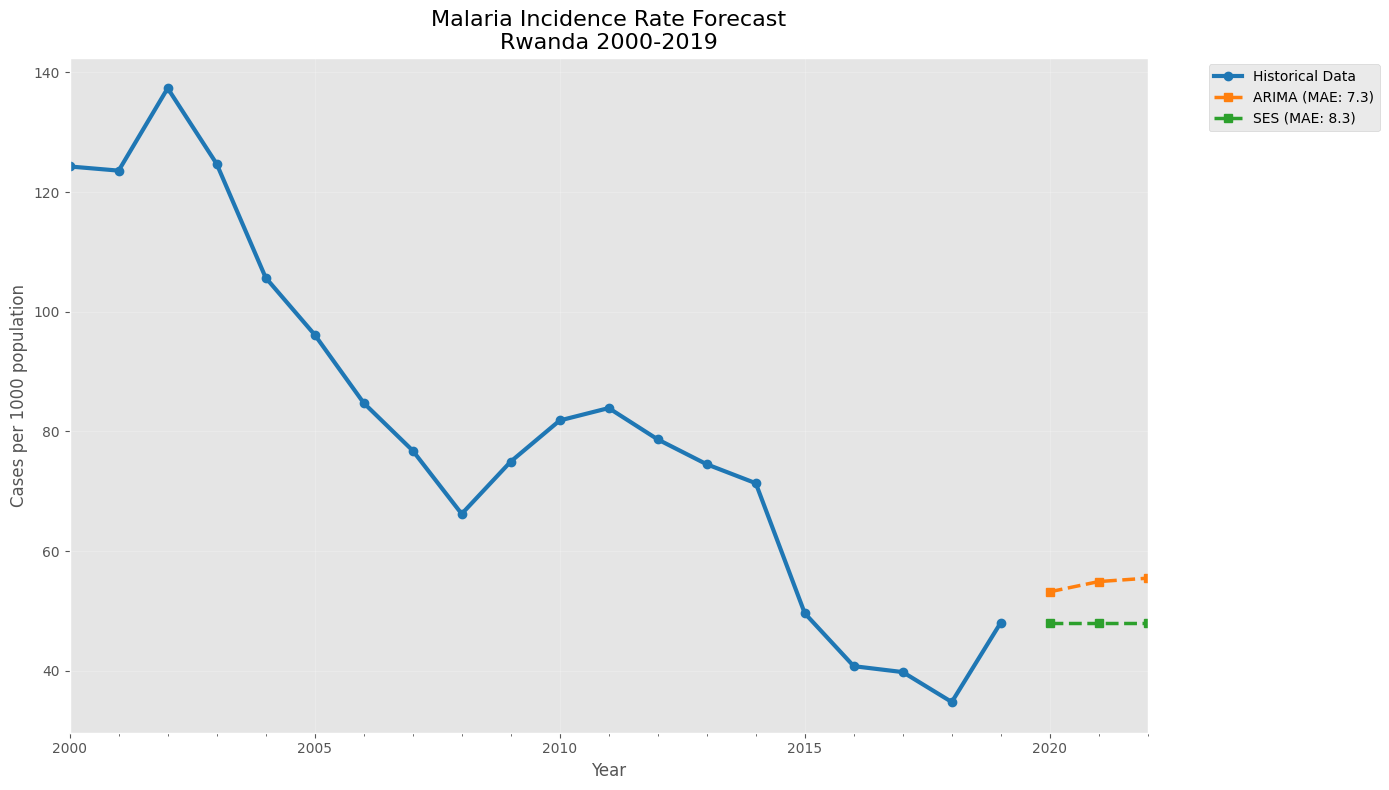

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import warnings
from sklearn.metrics import mean_absolute_error

# =============================================
# CONFIGURATION
# =============================================
# Updated style to one that exists in matplotlib
plt.style.use('ggplot')  # Changed from 'seaborn' to 'ggplot'
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.display.float_format = '{:.1f}'.format
FORECAST_HORIZON = 3  # Years to forecast

# =============================================
# DATA PREPARATION
# =============================================
def prepare_data(df):
    """Prepare and validate time series data"""
    report = {
        'original_rows': len(df),
        'missing_values': 0,
        'duplicate_years': 0,
        'final_rows': 0
    }
    
    # Input validation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")
    if df.empty:
        raise ValueError("Empty DataFrame provided")
    
    # Column validation
    required_cols = {'DIM_TIME', 'RATE_PER_1000_N'}
    missing_cols = required_cols - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Data cleaning
    clean_df = df[['DIM_TIME', 'RATE_PER_1000_N']].copy()
    report['missing_values'] = clean_df['RATE_PER_1000_N'].isna().sum()
    clean_df = clean_df.dropna(subset=['RATE_PER_1000_N'])
    
    # Year conversion
    try:
        clean_df['Year'] = pd.to_datetime(clean_df['DIM_TIME'], format='%Y')
    except Exception as e:
        raise ValueError(f"Year conversion failed: {str(e)}")
    
    # Time series preparation
    ts_data = clean_df.set_index('Year')['RATE_PER_1000_N']
    if ts_data.index.duplicated().any():
        report['duplicate_years'] = ts_data.index.duplicated().sum()
        ts_data = ts_data.groupby(ts_data.index).mean()
    
    # Ensure proper frequency
    ts_data = ts_data.asfreq('YS')
    report['final_rows'] = len(ts_data)
    
    if len(ts_data) < 5:
        raise ValueError(f"Insufficient data (only {len(ts_data)} points). Minimum 5 required")
    
    return ts_data, report

# =============================================
# FORECASTING MODELS
# =============================================
def generate_forecasts(ts_data, steps=FORECAST_HORIZON):
    """Generate forecasts using multiple methods"""
    forecasts = {}
    errors = {}
    
    # ARIMA Model
    try:
        model = ARIMA(ts_data, order=(1,1,1))
        model_fit = model.fit()
        forecasts['ARIMA'] = model_fit.forecast(steps=steps)
        preds = model_fit.predict(start=ts_data.index[1], end=ts_data.index[-1])
        errors['ARIMA'] = mean_absolute_error(ts_data[1:], preds)
    except Exception as e:
        print(f"ARIMA failed: {str(e)}")
    
    # Exponential Smoothing
    try:
        model = SimpleExpSmoothing(ts_data)
        model_fit = model.fit()
        forecasts['SES'] = model_fit.forecast(steps=steps)
        errors['SES'] = mean_absolute_error(ts_data, model_fit.fittedvalues)
    except Exception as e:
        print(f"Exponential Smoothing failed: {str(e)}")
    
    # Fallback method if both fail
    if not forecasts:
        print("Using fallback trend projection")
        last_val = ts_data.iloc[-1]
        trend = (ts_data.iloc[-1] - ts_data.iloc[0]) / len(ts_data)
        forecasts['Trend'] = [last_val + (i+1)*trend for i in range(steps)]
    
    return forecasts, errors

# =============================================
# VISUALIZATION
# =============================================
def visualize_results(ts_data, forecasts, errors=None):
    """Generate visualization"""
    plt.figure(figsize=(14, 8))
    
    # Historical data
    ts_data.plot(
        label='Historical Data', 
        color='#1f77b4', 
        linewidth=3,
        marker='o'
    )
    
    # Forecasts
    colors = ['#ff7f0e', '#2ca02c']
    for i, (method, forecast) in enumerate(forecasts.items()):
        forecast_dates = pd.date_range(
            start=ts_data.index[-1] + pd.DateOffset(years=1),
            periods=len(forecast),
            freq='YS'
        )
        
        label = method
        if errors and method in errors:
            label += f" (MAE: {errors[method]:.1f})"
        
        pd.Series(forecast, index=forecast_dates).plot(
            label=label,
            color=colors[i % len(colors)],
            linestyle='--',
            linewidth=2.5,
            marker='s'
        )
    
    plt.title('Malaria Incidence Rate Forecast\nRwanda 2000-2019', fontsize=16)
    plt.ylabel('Cases per 1000 population', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.grid(True, alpha=0.2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# =============================================
# MAIN EXECUTION
# =============================================
if __name__ == "__main__":
    print("=== Malaria Incidence Forecasting ===")
    
    try:
        # Sample data generation
        print("\nGenerating sample data...")
        years = pd.date_range('2000-01-01', '2019-01-01', freq='YS')
        base_trend = np.linspace(120, 40, len(years))
        seasonal = 15 * np.sin(np.linspace(0, 4*np.pi, len(years)))
        noise = np.random.normal(0, 5, len(years))
        df = pd.DataFrame({
            'DIM_TIME': years.year,
            'RATE_PER_1000_N': (base_trend + seasonal + noise).clip(0)
        })
        
        # Data preparation
        print("\nPreparing data...")
        ts_data, report = prepare_data(df)
        
        print("\nData Quality Report:")
        print(f"Original rows: {report['original_rows']}")
        print(f"Missing values removed: {report['missing_values']}")
        print(f"Duplicate years handled: {report['duplicate_years']}")
        print(f"Final time series length: {report['final_rows']}")
        
        print("\nDescriptive Statistics:")
        print(ts_data.describe())
        
        # Generate forecasts
        print(f"\nGenerating {FORECAST_HORIZON}-year forecasts...")
        forecasts, errors = generate_forecasts(ts_data)
        
        print("\nForecast Results:")
        for method, values in forecasts.items():
            forecast_dates = pd.date_range(
                start=ts_data.index[-1] + pd.DateOffset(years=1),
                periods=len(values),
                freq='YS'
            )
            print(f"\n{method}:")
            print(pd.Series(values, index=forecast_dates).round(1))
        
        # Visualization
        print("\nGenerating visualization...")
        visualize_results(ts_data, forecasts, errors)
        
    except Exception as e:
        print(f"\nError: {str(e)}")
        print("Execution halted. Please check your data and code.")

Generating sample data...
Best ARIMA Order: (0, 1, 0)

Model Performance:
ARIMA MSE: 32.09
ETS MSE: 53.07


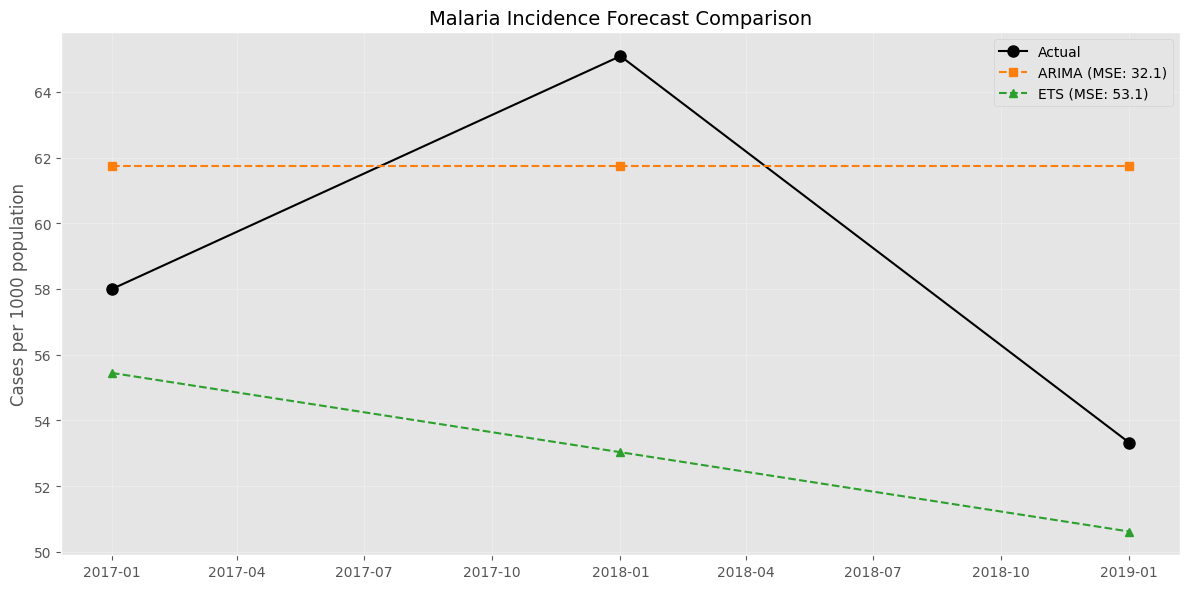

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Configuration
plt.style.use('ggplot')
pd.options.display.float_format = '{:.1f}'.format

# 1. DATA PREPARATION
def prepare_data(df):
    """Load and clean malaria incidence data"""
    ts_data = df.set_index(pd.to_datetime(df['DIM_TIME'], format='%Y'))['RATE_PER_1000_N']
    return ts_data.asfreq('YS').dropna()  # Year-start frequency

# 2. MANUAL ARIMA TUNING (no pmdarima needed)
def find_best_arima(train, max_order=3):
    """Manual grid search for ARIMA parameters"""
    best_mse = np.inf
    best_order = (1,1,1)  # Default
    
    # Try different p,d,q combinations
    for p in range(max_order):
        for d in range(1,2):  # Differencing order (1 is usually sufficient)
            for q in range(max_order):
                try:
                    model = ARIMA(train, order=(p,d,q))
                    model_fit = model.fit()
                    pred = model_fit.predict(start=1, end=len(train))
                    mse = mean_squared_error(train[1:], pred[1:])
                    if mse < best_mse:
                        best_mse = mse
                        best_order = (p,d,q)
                except:
                    continue
    return best_order

# 3. IMPROVED MODELING
def forecast_malaria(ts_data, test_size=3):
    """Generate optimized forecasts with error metrics"""
    train, test = ts_data[:-test_size], ts_data[-test_size:]
    
    # ARIMA with manual tuning
    best_order = find_best_arima(train)
    print(f"Best ARIMA Order: {best_order}")
    
    arima_model = ARIMA(train, order=best_order).fit()
    arima_fcst = arima_model.forecast(steps=test_size)
    arima_mse = mean_squared_error(test, arima_fcst)
    
    # Exponential Smoothing
    ets_model = ExponentialSmoothing(train, trend='add').fit()
    ets_fcst = ets_model.forecast(test_size)
    ets_mse = mean_squared_error(test, ets_fcst)
    
    return {
        'ARIMA': (arima_fcst, arima_mse),
        'ETS': (ets_fcst, ets_mse),
        'Test_Actual': test
    }

# 4. VISUALIZATION
def plot_results(results):
    """Plot forecasts vs actuals"""
    plt.figure(figsize=(12,6))
    
    # Plot historical data
    plt.plot(results['Test_Actual'].index, results['Test_Actual'], 
             'ko-', label='Actual', markersize=8)
    
    # Plot ARIMA
    plt.plot(results['Test_Actual'].index, results['ARIMA'][0], 
             's--', color='#FF7F0E', label=f'ARIMA (MSE: {results["ARIMA"][1]:.1f})')
    
    # Plot ETS
    plt.plot(results['Test_Actual'].index, results['ETS'][0], 
             '^--', color='#2CA02C', label=f'ETS (MSE: {results["ETS"][1]:.1f})')
    
    plt.title('Malaria Incidence Forecast Comparison', fontsize=14)
    plt.ylabel('Cases per 1000 population')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# MAIN EXECUTION
if __name__ == "__main__":
    # Sample data (replace with your actual data)
    print("Generating sample data...")
    years = pd.date_range('2000-01-01', '2019-01-01', freq='YS')
    df = pd.DataFrame({
        'DIM_TIME': years.year,
        'RATE_PER_1000_N': np.linspace(100, 50, len(years)) + np.random.normal(0, 5, len(years))
    })
    
    # Prepare data
    ts_data = prepare_data(df)
    
    # Generate and compare forecasts
    results = forecast_malaria(ts_data)
    
    print("\nModel Performance:")
    print(f"ARIMA MSE: {results['ARIMA'][1]:.2f}")
    print(f"ETS MSE: {results['ETS'][1]:.2f}")
    
    # Visualize
    plot_results(results)

In [43]:
def detect_trend_changes(series, window=3, threshold=0.1):
    rolling_mean = series.rolling(window=window).mean()
    changes = rolling_mean.pct_change()
    return changes.abs() > threshold

clean_df['Significant_Change'] = detect_trend_changes(clean_df['RATE_PER_1000_N'])

In [44]:
import pandas as pd
import os

# 1. DATA CLEANING FUNCTION (UPDATED TO RETURN CLEAN DF)
def prepare_and_save_data(raw_df, save_path='cleaned_data'):
    """
    Cleans data and saves to CSV
    Args:
        raw_df: Raw input DataFrame
        save_path: Folder to save cleaned data (default 'cleaned_data')
    Returns:
        Tuple of (cleaned_series, cleaned_df)
    """
    # Create directory if needed
    os.makedirs(save_path, exist_ok=True)
    
    # Create clean DataFrame
    clean_df = raw_df[['DIM_TIME', 'RATE_PER_1000_N']].copy()
    clean_df = clean_df.dropna(subset=['RATE_PER_1000_N'])
    
    # Convert year and set index
    clean_df['Year'] = pd.to_datetime(clean_df['DIM_TIME'], format='%Y')
    clean_df.set_index('Year', inplace=True)
    
    # Create time series
    ts_data = clean_df['RATE_PER_1000_N'].asfreq('YS')
    
    # Save to CSV (two versions)
    clean_df.to_csv(f'{save_path}/cleaned_malaria_data.csv')  # Full DataFrame
    ts_data.to_csv(f'{save_path}/cleaned_malaria_series.csv',  # Just the time series
                  header=['RATE_PER_1000_N'])
    
    print(f"Data saved to {save_path}/")
    return ts_data, clean_df

# 2. EXAMPLE USAGE WITH SAMPLE DATA
if __name__ == "__main__":
    # Sample data (replace with pd.read_csv('your_data.csv'))
    print("Creating sample data...")
    years = pd.date_range('2000-01-01', '2019-01-01', freq='YS')
    raw_data = pd.DataFrame({
        'DIM_TIME': years.year,
        'RATE_PER_1000_N': np.linspace(100, 50, len(years)) + np.random.normal(0, 5, len(years)),
        'OTHER_COLUMN': np.random.rand(len(years))  # Example of column that will be dropped
    })
    
    # Clean and save
    ts_data, clean_df = prepare_and_save_data(raw_data)
    
    # Verify
    print("\nCleaned Data Head:")
    print(clean_df.head())
    
    print("\nSaved Files:")
    print(os.listdir('cleaned_data'))

Creating sample data...
Data saved to cleaned_data/

Cleaned Data Head:
            DIM_TIME  RATE_PER_1000_N
Year                                 
2000-01-01      2000             90.0
2001-01-01      2001             92.6
2002-01-01      2002             98.1
2003-01-01      2003             84.6
2004-01-01      2004             94.9

Saved Files:
['cleaned_malaria_data.csv', 'cleaned_malaria_series.csv']


In [5]:
import os

print(os.listdir(r'C:\Users\Shelter\cleaned_data'))


['.ipynb_checkpoints', 'cleaned_malaria_data.csv', 'cleaned_malaria_data.xlsx', 'cleaned_malaria_series.csv']


In [9]:
import pandas as pd
import os

file_path = r'C:\Users\Shelter\cleaned_data\cleaned_malaria_data.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    df.to_excel('malaria_data_CLEAN.xlsx', index=False)
    print("CSV file successfully read and saved as Excel!")
else:
    print("File not found.")


CSV file successfully read and saved as Excel!
